<a href="https://colab.research.google.com/github/chunsengwong/the-speech-emotion-recognition/blob/main/ASS%2BSER2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import io
import pandas as pd
from google.colab import files

print("Choose a single file")

uploaded = files.upload()

filename=[key for key in uploaded.keys()][0]

Choose a single file


Saving focus-cache-352904-21b9fded3bd2.json to focus-cache-352904-21b9fded3bd2.json


In [2]:
from matplotlib.pyplot import fill
import pickle
import librosa
from librosa import feature
import soundfile
import numpy as np
import os
#install google cloud speech
!pip install --upgrade google-cloud-speech
!pip install pydub
from google.cloud import speech

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.6/273.6 kB 16.4 MB/s eta 0:00:00


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pydub
!pip install pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [8]:
#set google environment & credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS']= '/content/focus-cache-352904-21b9fded3bd2.json'
speech_client=speech.SpeechClient()
from pydub import AudioSegment
from pydub.playback import play
from IPython.display import Audio, display


In [49]:
path="/content/sample.wav"# Load the audio file
audio = AudioSegment.from_wav(path)

# Set the desired sample rate (in Hz)
new_sample_rate = 16000

# Resample the audio to the desired sample rate
resampled_audio = audio.set_frame_rate(new_sample_rate)
# Convert the audio to the desired sample width
resampled_audio = audio.set_sample_width(2)
# Export the resampled audio to a new WAV file
resampled_audio.export('/content/output.wav', format='wav')
with open('/content/output.wav', "rb") as audio_file:
    wavfile = audio_file.read()
#import for audio functions
audioWav = speech.RecognitionAudio(content=wavfile)

#create class for audio
class Audioseg:
  def __init__(self, path, start, end):
    self.starttime=start*1000
    self.endtime = end*1000
    self.path=path

#configure wav file
configWav = speech.RecognitionConfig(
       encoding = 'LINEAR16',
        language_code = 'en_us',
        sample_rate_hertz = 48000,
        #audio_channel_count = 2,
        enable_automatic_punctuation=True,
        enable_word_time_offsets=True
)

def extractFeature (fileName, mfcc, chroma, mel ):
    with soundfile.SoundFile(fileName) as soundFile:
        X=soundFile.read(dtype="float32")
        sampleRate=soundFile.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sampleRate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))

        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sampleRate).T, axis=0)
            result=np.hstack((result, chroma))

        if mel:
            mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sampleRate).T,axis=0)
            result=np.hstack((result,mel))


    return result

import joblib
loaded_model = pickle.load(open("SER.sav", 'rb'))
def MLPfunction(feature):
    #loaded_model = pickle.load(open("SER.sav", 'rb'))
    y_pre=loaded_model.predict([feature])
    #print(y_pre)
    return y_pre



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [52]:
#transcript and automatic punctuation added

response = speech_client.long_running_recognize(config=configWav, audio=audioWav)
done=0
#a list to store audio fragments
audioList=[]
AudioS=[]
sentences=[]
sentencesWords=""
print("Original audio: ")
display(AudioSegment.from_wav(path))

print("Waiting for operation to complete...\n\n-------------------------------------")
print("Transcript: \n")
response = response.result(timeout=90)

for result in response.results:
    #pattern = r'\b([A-Z][a-z]*\.){2,}|[A-Z]+\b'
    #result = re.sub(pattern, lambda x: x.group().replace('.', ''), text)

    print("{}".format(result.alternatives[0].transcript))

print("\n observed emotion: ['sad', 'fearful', 'surprised', 'happy']\n")
for i, result in enumerate(response.results):
    alternative = result.alternatives[0]
    #print("-" * 20)
    #print("First alternative of result {}".format(i))
    #print("{}".format(alternative.transcript))
    for word_info in alternative.words:
            word = word_info.word
            start_time = word_info.start_time
            end_time = word_info.end_time
            sentencesWords=sentencesWords+" "+word

            if(done==0):
                start=start_time.total_seconds()
                done=1

            #if word[-1]=='.' :

            if word[-1]=='.' or word[-1]=='!' or word[-1]=='?' :
                  done=0
                  sentences.append(sentencesWords)
                  sentencesWords=""
                  AudioS.append(Audioseg(path, start, end_time.total_seconds()))
                  newAudio = AudioSegment.from_wav(AudioS[len(AudioS)-1].path)
                  newAudio = newAudio[AudioS[len(AudioS)-1].starttime:AudioS[len(AudioS)-1].endtime]
                  audioList.append(newAudio)
                  #print("path: " , AudioS[len(AudioS)-1].path , "\n", (AudioS[len(AudioS)-1].starttime/1000) , ": ", (AudioS[len(AudioS)-1].endtime/1000), " (second)")

print(f"\n\n\nAudio fragments (total {(len(audioList))+1}):")
j=0
emotionData=[]
for i in audioList:
  print("Sentence " , (j+1) , ":", sentences[j])
  #print(len(sentences))
  display(i)
  i.export("temp.wav", format="wav")
  print("path: " , AudioS[j].path , "\n", (AudioS[j].starttime/1000) , ": ", (AudioS[j].endtime/1000), " (second)")
  j=j+1
  feature=extractFeature("temp.wav", mfcc=True, chroma=True, mel=True)
  print("Result: ", MLPfunction(feature))

  #emotionData.append(MLPfunction(feature))
  print("\n")


Original audio: 


Waiting for operation to complete...

-------------------------------------
Transcript: 

The Navy attacked the big task force.
 Feed the cat glaring at the scared Mouse.
 Sara Moulton to Fox's hair.
 The Hat brim with wide and two droopy.
 The lawyer trying to lose his case.
 The Girl Scout around the fence post.
 Cut the pie into large parts.
 Men Strife, but seldom get rich.
 Always close the Barn Door tight.
 He lay prone and hardly move the limb.

 observed emotion: ['sad', 'fearful', 'surprised', 'happy']




Audio fragments (total 11):
Sentence  1 :  The Navy attacked the big task force.


path:  /content/sample.wav 
 0.1 :  2.6  (second)
Result:  ['surprised']


Sentence  2 :  Feed the cat glaring at the scared Mouse.


path:  /content/sample.wav 
 5.0 :  7.3  (second)
Result:  ['surprised']


Sentence  3 :  Sara Moulton to Fox's hair.


path:  /content/sample.wav 
 9.7 :  11.7  (second)
Result:  ['happy']


Sentence  4 :  The Hat brim with wide and two droopy.


path:  /content/sample.wav 
 14.7 :  17.0  (second)
Result:  ['happy']


Sentence  5 :  The lawyer trying to lose his case.


path:  /content/sample.wav 
 19.5 :  21.5  (second)
Result:  ['fearful']


Sentence  6 :  The Girl Scout around the fence post.


path:  /content/sample.wav 
 24.2 :  26.3  (second)
Result:  ['happy']


Sentence  7 :  Cut the pie into large parts.


path:  /content/sample.wav 
 29.3 :  31.6  (second)
Result:  ['surprised']


Sentence  8 :  Men Strife, but seldom get rich.


path:  /content/sample.wav 
 33.9 :  36.3  (second)
Result:  ['surprised']


Sentence  9 :  Always close the Barn Door tight.


path:  /content/sample.wav 
 38.7 :  40.8  (second)
Result:  ['surprised']


Sentence  10 :  He lay prone and hardly move the limb.


path:  /content/sample.wav 
 43.3 :  45.6  (second)
Result:  ['happy']




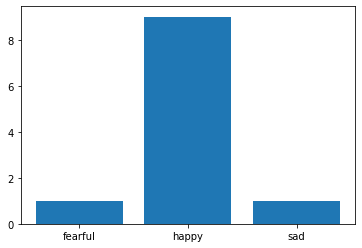

In [ ]:
#plot bars
from matplotlib import pyplot as plt
keys, counts = np.unique(emotionData, return_counts=True)
plt.bar(keys, counts)
plt.show()

In [ ]:
emotionData.count("happy")
import pandas as pd
abc=pd.Series(emotionData).value_counts().reset_index().values.tolist()
print(*abc, sep = "\n")

[array(['happy'], dtype='<U9'), 9]
[array(['sad'], dtype='<U9'), 1]
[array(['fearful'], dtype='<U9'), 1]


In [ ]:
print(*abc, sep = ", ")

[array(['happy'], dtype='<U9'), 9], [array(['sad'], dtype='<U9'), 1], [array(['fearful'], dtype='<U9'), 1]
